In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from ucimlrepo import fetch_ucirepo

# For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Classifiers to compare
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [5]:
print("Loading Online Retail dataset...")
online_retail = fetch_ucirepo(id=352)
df = pd.concat([online_retail.data['ids'], online_retail.data.features], axis=1)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")

Loading Online Retail dataset...
Dataset loaded with 541909 rows and 8 columns


In [6]:
# Data Preprocessing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

# 2.2 Create target variable: Is this a cancelled transaction?
df['IsCancelled'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)

# Check how many cancellations we have
cancellation_counts = df['IsCancelled'].value_counts()
print("\nTransaction Cancellation Distribution:")
print(cancellation_counts)
print(f"Cancellation Rate: {cancellation_counts[1] / len(df) * 100:.2f}%")

# 2.3 Calculate total transaction value
df['TotalValue'] = df['Quantity'] * df['UnitPrice']

# 2.4 Extract useful time features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour


Transaction Cancellation Distribution:
IsCancelled
0    532621
1      9288
Name: count, dtype: int64
Cancellation Rate: 1.71%


In [7]:
# Feature Engineering

# Group by invoice to get transaction-level features
invoice_features = df.groupby('InvoiceNo').agg({
    'StockCode': 'nunique',  # Number of unique products
    'Quantity': 'sum',       # Total quantity of items
    'TotalValue': 'sum',     # Total transaction value
    'CustomerID': 'first',   # Customer who made the transaction
    'Country': 'first',      # Country where the transaction was made
    'Year': 'first',
    'Month': 'first',
    'Day': 'first',
    'DayOfWeek': 'first',
    'Hour': 'first',
    'IsCancelled': 'first',  # Whether this transaction was cancelled
    'InvoiceDate': 'first'   # ADDED THIS LINE - Keep the invoice date for time-based features
}).reset_index()

# Rename columns for clarity
invoice_features.rename(columns={
    'StockCode': 'NumUniqueProducts',
    'Quantity': 'TotalQuantity'
}, inplace=True)

# Add a weekday/weekend feature
invoice_features['IsWeekend'] = invoice_features['DayOfWeek'].isin([5, 6]).astype(int)

# Handle missing CustomerIDs
customer_id_missing = invoice_features['CustomerID'].isna().sum()
print(f"\nTransactions with missing CustomerID: {customer_id_missing} ({customer_id_missing / len(invoice_features) * 100:.2f}%)")

# For simplicity, we'll fill missing CustomerIDs with a placeholder value
invoice_features['CustomerID'] = invoice_features['CustomerID'].fillna(-1)

# Create features for customers
# Get customer purchase history before each transaction
customer_history = pd.DataFrame()

# Sort by invoice date to ensure we're only looking at past transactions
invoice_features = invoice_features.sort_values('InvoiceDate')

for _, invoice in invoice_features.iterrows():
    if invoice['CustomerID'] == -1:  # Skip transactions with unknown customers
        continue
        
    # Get all previous transactions by this customer
    customer_prev_invoices = invoice_features[
        (invoice_features['CustomerID'] == invoice['CustomerID']) &
        (invoice_features['InvoiceDate'] < invoice['InvoiceDate'])
    ]
    
    if len(customer_prev_invoices) > 0:
        # Calculate customer metrics
        history_row = {
            'InvoiceNo': invoice['InvoiceNo'],
            'PreviousTransactions': len(customer_prev_invoices),
            'PreviousCancellations': customer_prev_invoices['IsCancelled'].sum(),
            'AvgTransactionValue': customer_prev_invoices['TotalValue'].mean(),
            'TotalSpent': customer_prev_invoices['TotalValue'].sum()
        }
        customer_history = pd.concat([customer_history, pd.DataFrame([history_row])], ignore_index=True)

# Merge customer history with invoice features
invoice_features = pd.merge(invoice_features, customer_history, on='InvoiceNo', how='left')

# Fill NAs in the customer history columns (for new customers)
history_cols = ['PreviousTransactions', 'PreviousCancellations', 'AvgTransactionValue', 'TotalSpent']
invoice_features[history_cols] = invoice_features[history_cols].fillna(0)

# Add cancellation rate feature
invoice_features['PrevCancellationRate'] = np.where(
    invoice_features['PreviousTransactions'] > 0,
    invoice_features['PreviousCancellations'] / invoice_features['PreviousTransactions'],
    0
)

# Drop the InvoiceDate column as we don't need it for modeling
# But keep it in case we need date-based analysis
invoice_features_with_date = invoice_features.copy()
invoice_features = invoice_features.drop('InvoiceDate', axis=1)


Transactions with missing CustomerID: 3710 (14.32%)


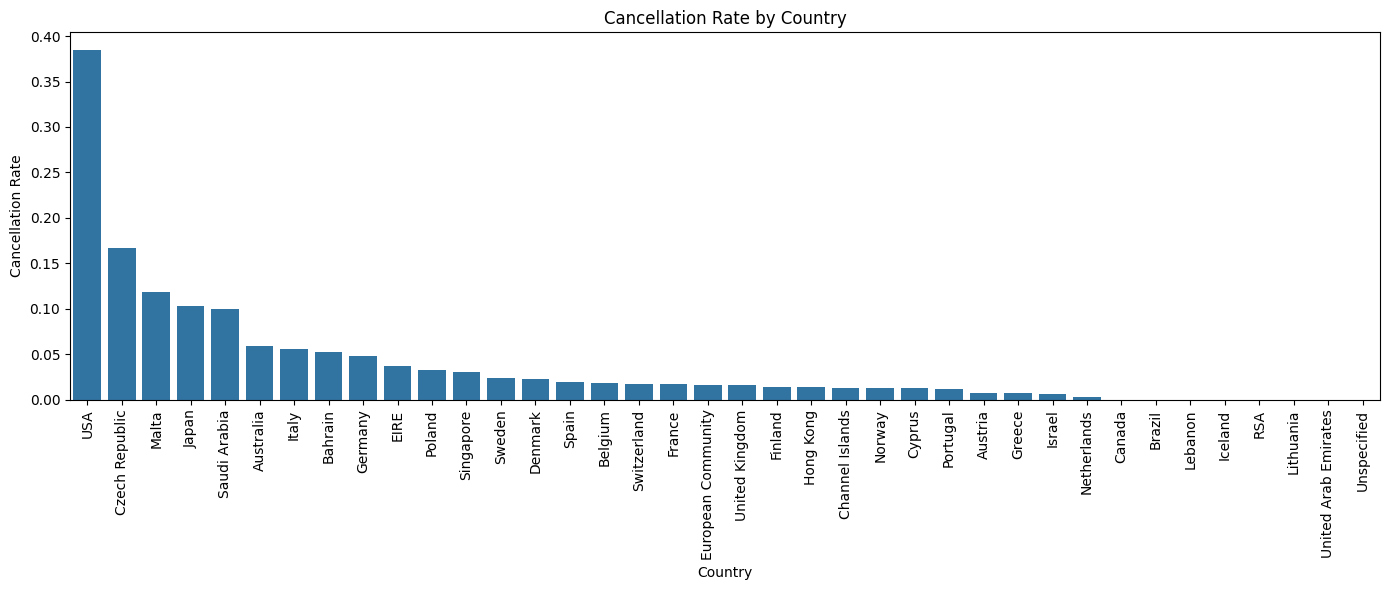

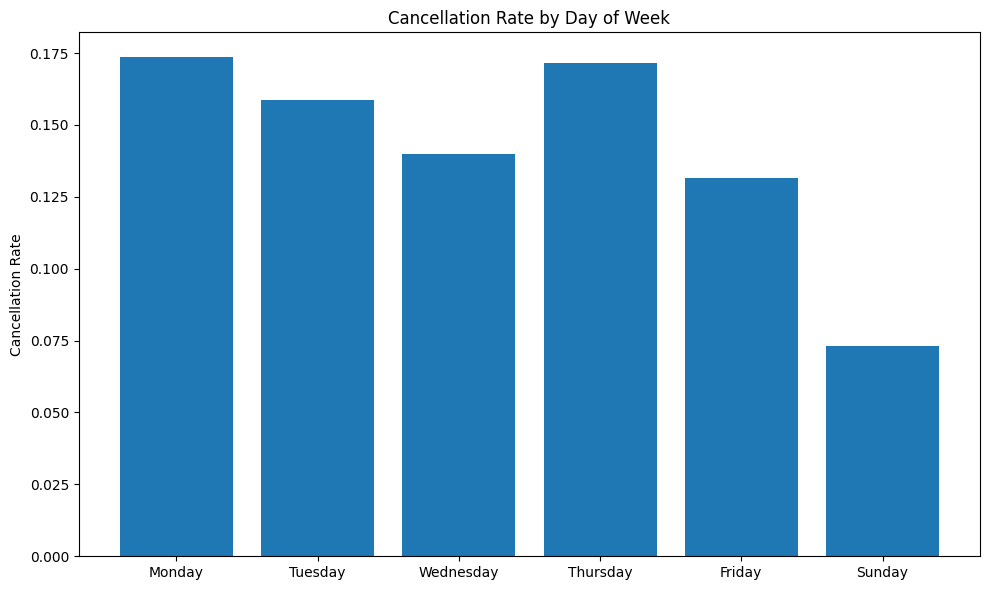

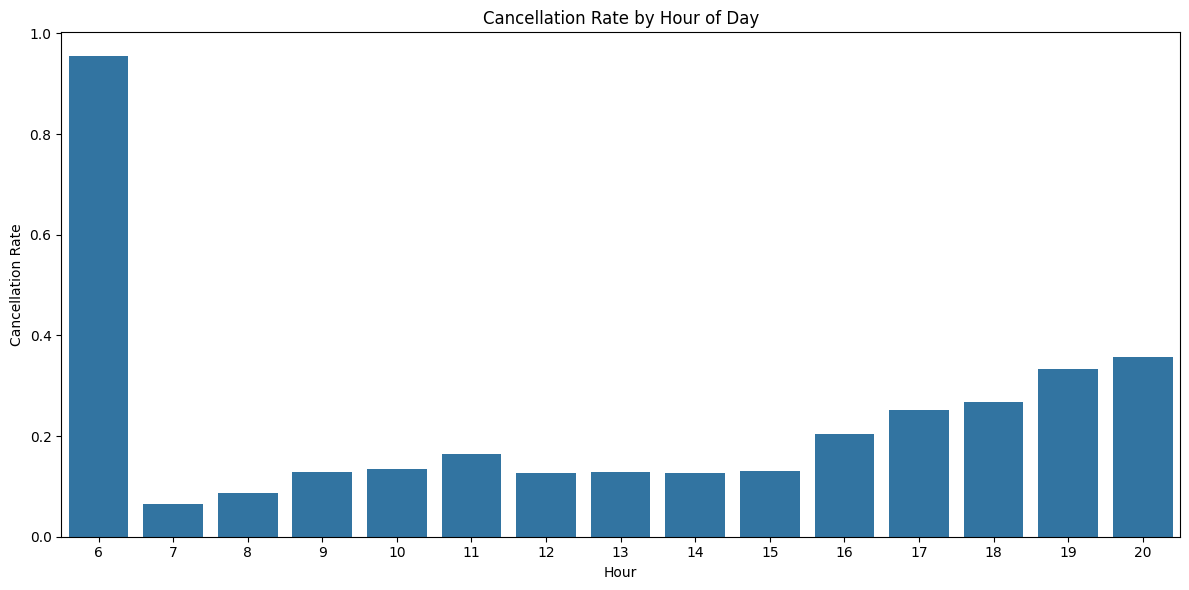

In [17]:
# Explore Relationships Between Features and Cancellations

# Plot cancellation rate by country
plt.figure(figsize=(14, 6))
country_cancel_rate = df.groupby('Country')['IsCancelled'].mean().sort_values(ascending=False)
sns.barplot(x=country_cancel_rate.index, y=country_cancel_rate.values)
plt.title('Cancellation Rate by Country')
plt.xticks(rotation=90)
plt.ylabel('Cancellation Rate')
plt.tight_layout()
plt.show()

# 4.2 Plot cancellation rate by day of week - FIXED
plt.figure(figsize=(10, 6))

# Get the actual days present in the data
day_cancel_rate = invoice_features.groupby('DayOfWeek')['IsCancelled'].mean()

# Create a mapping for day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create x-labels showing only days that exist in the data
x_labels = [day_names[day] for day in day_cancel_rate.index]

# Plot using the indexes that exist and the corresponding labels
plt.bar(range(len(day_cancel_rate)), day_cancel_rate.values)
plt.xticks(range(len(day_cancel_rate)), x_labels)

plt.title('Cancellation Rate by Day of Week')
plt.ylabel('Cancellation Rate')
plt.tight_layout()
plt.show()

# Plot cancellation rate by hour of day
plt.figure(figsize=(12, 6))
hour_cancel_rate = invoice_features.groupby('Hour')['IsCancelled'].mean()
sns.barplot(x=hour_cancel_rate.index, y=hour_cancel_rate.values)
plt.title('Cancellation Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Cancellation Rate')
plt.tight_layout()
plt.show()

In [11]:
# Prepare Data for Modeling

# Select features for modeling
features = [
    'NumUniqueProducts', 'TotalQuantity', 'TotalValue',
    'Month', 'DayOfWeek', 'Hour', 'IsWeekend',
    'PreviousTransactions', 'PrevCancellationRate', 'AvgTransactionValue'
]

# Add country as a feature (selecting top countries and grouping the rest)
top_countries = df['Country'].value_counts().nlargest(5).index
invoice_features['CountryGroup'] = invoice_features['Country'].apply(
    lambda x: x if x in top_countries else 'Other'
)
features.append('CountryGroup')

# Split into train and test sets
X = invoice_features[features]
y = invoice_features['IsCancelled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create preprocessing pipeline
numeric_features = [
    'NumUniqueProducts', 'TotalQuantity', 'TotalValue',
    'Month', 'DayOfWeek', 'Hour', 'IsWeekend',
    'PreviousTransactions', 'PrevCancellationRate', 'AvgTransactionValue'
]
categorical_features = ['CountryGroup']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


Training set: 20720 samples
Test set: 5180 samples



Training and evaluating classifiers...

Training Logistic Regression...
Logistic Regression accuracy: 0.8639
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      4413
           1       0.52      1.00      0.69       767

    accuracy                           0.86      5180
   macro avg       0.76      0.92      0.80      5180
weighted avg       0.93      0.86      0.88      5180


Training Random Forest...
Random Forest accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4413
           1       1.00      1.00      1.00       767

    accuracy                           1.00      5180
   macro avg       1.00      1.00      1.00      5180
weighted avg       1.00      1.00      1.00      5180


Training Gradient Boosting...
Gradient Boosting accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4413
   

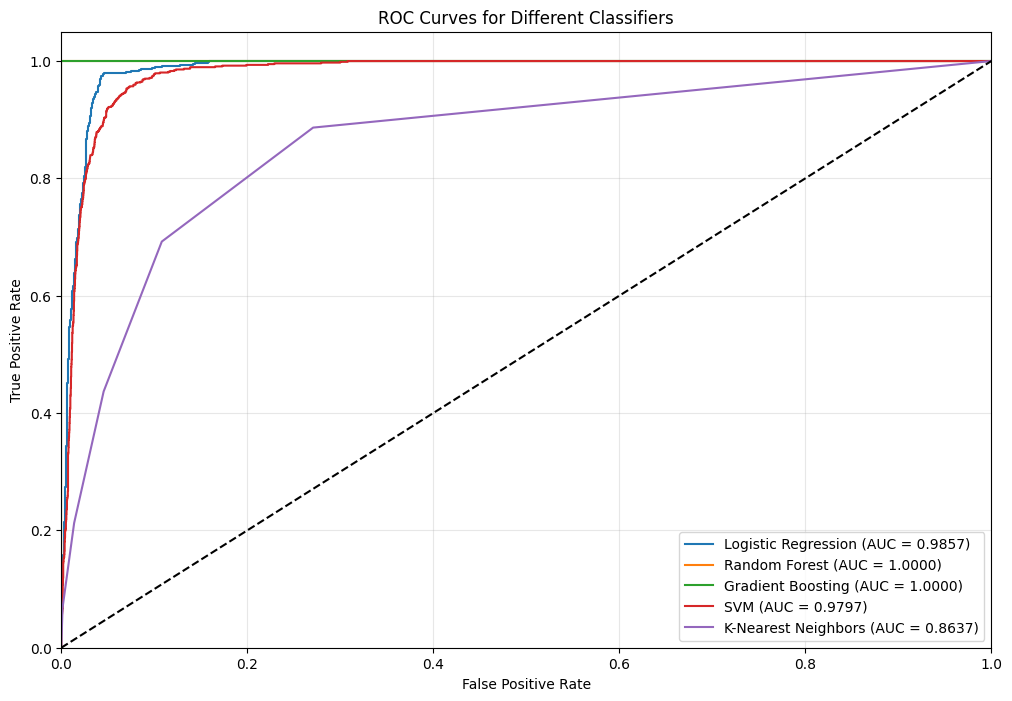

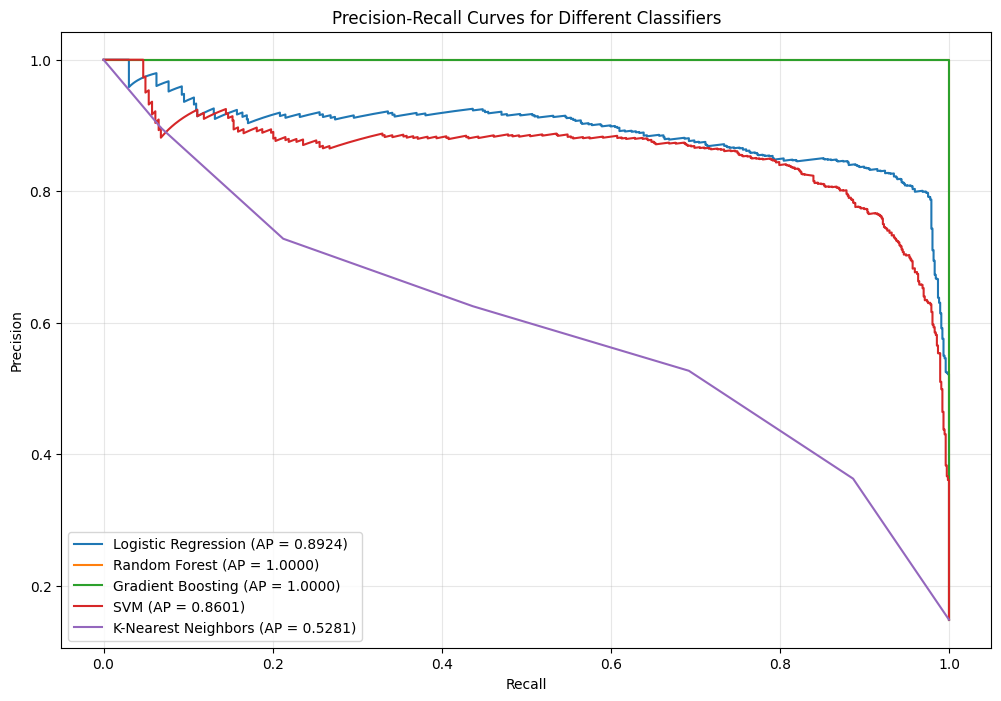

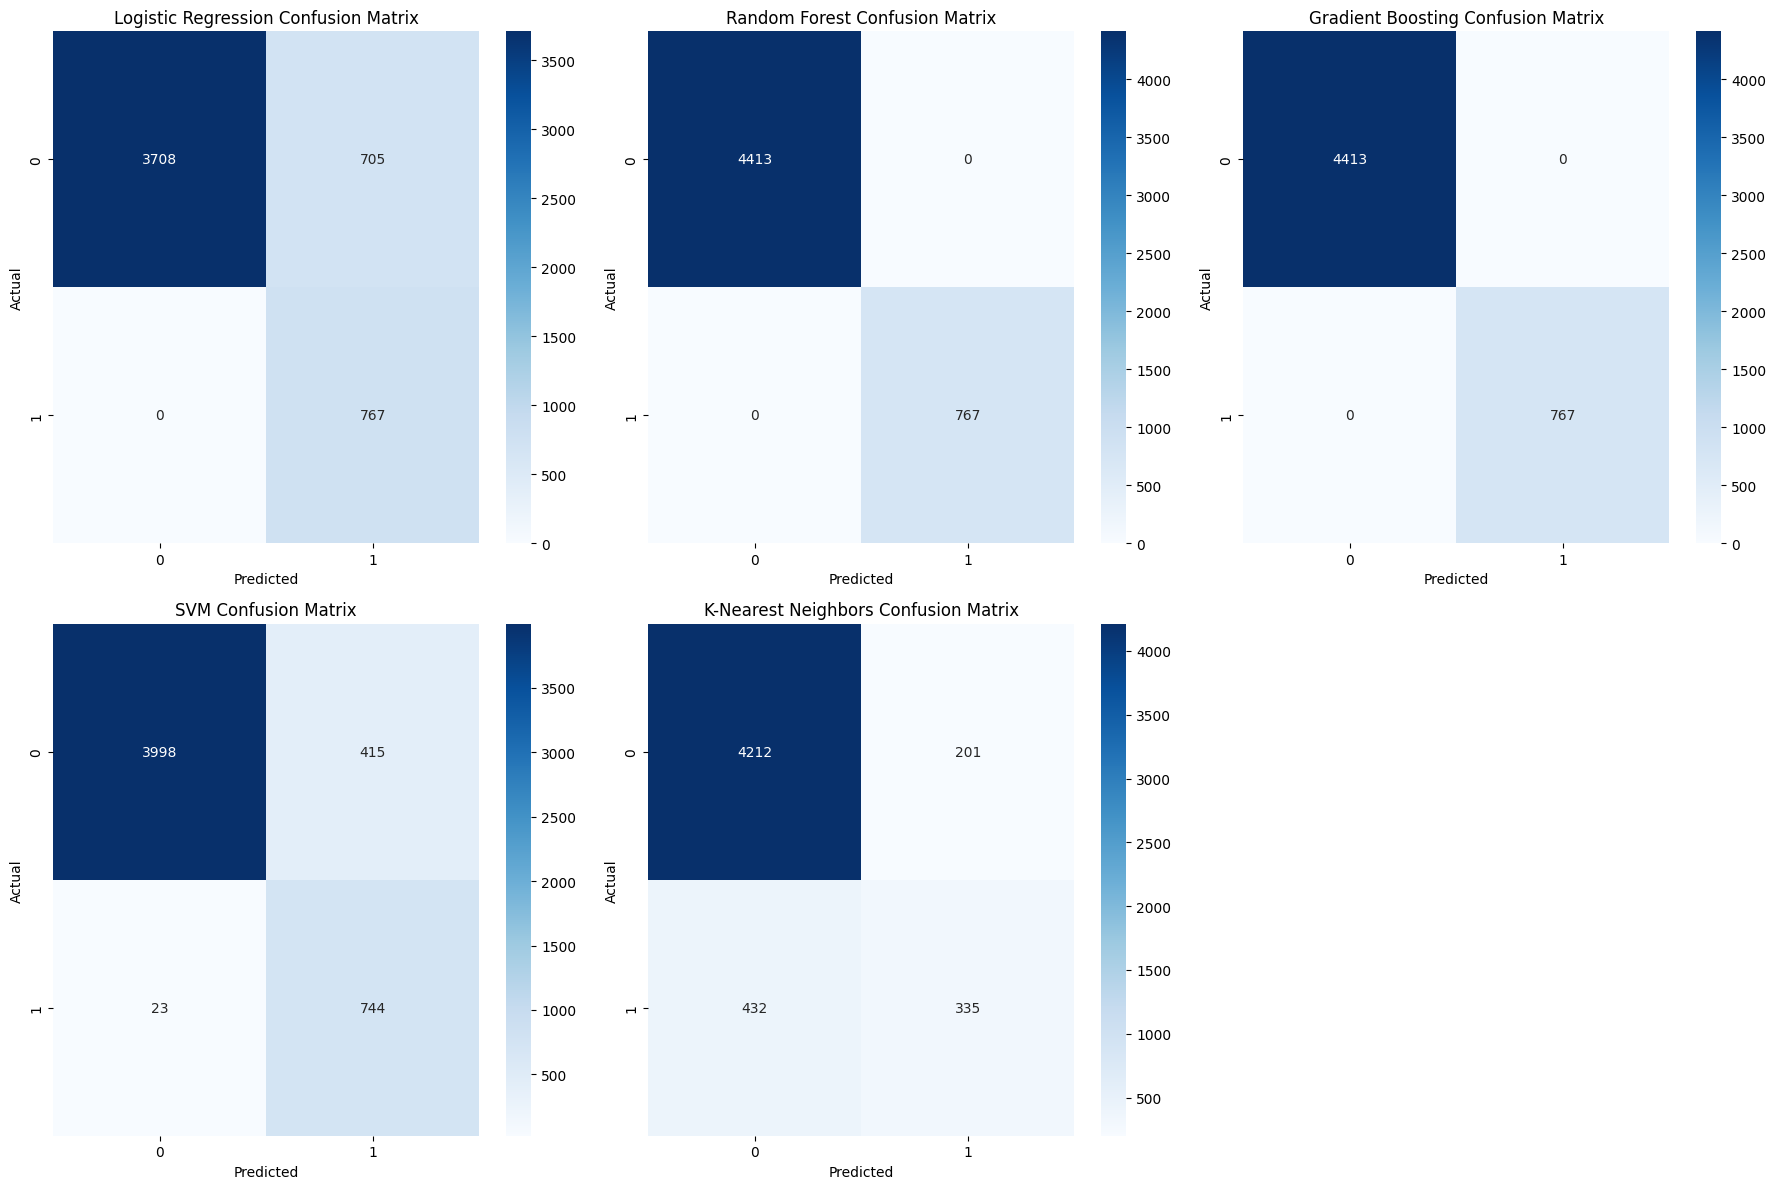

In [12]:
# Build and Compare Classifiers

# Define classifiers to compare
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "SVM": SVC(probability=True, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Results dictionary
results = {}

# Train and evaluate each classifier
print("\nTraining and evaluating classifiers...")

for name, classifier in classifiers.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline with preprocessing and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    
    # Get probabilities for ROC curve
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'pipeline': pipeline
    }
    
    print(f"{name} accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Plot ROC curves for all classifiers
plt.figure(figsize=(12, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Plot precision-recall curves
plt.figure(figsize=(12, 8))

for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_proba'])
    avg_precision = average_precision_score(y_test, result['y_proba'])
    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Classifiers')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

# Compare classifiers' confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    if i < len(axes):
        cm = confusion_matrix(y_test, result['y_pred'])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

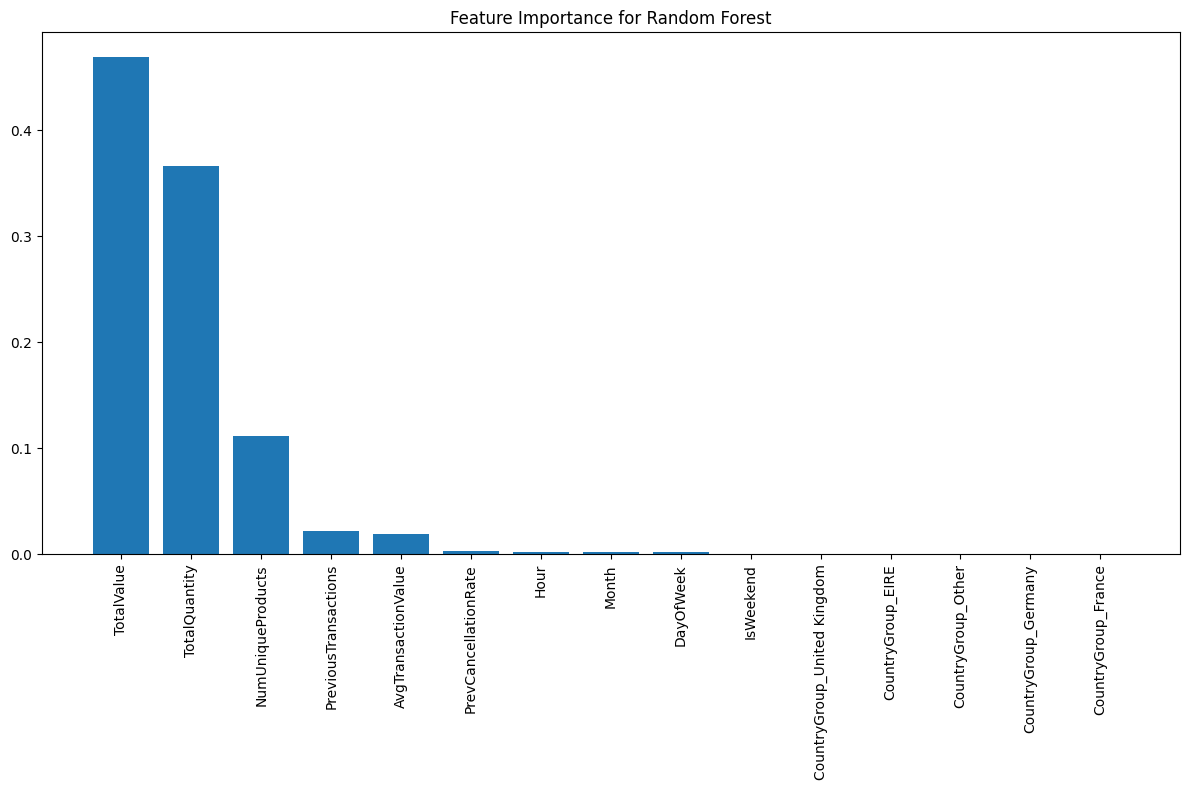

In [13]:
# Feature Importance Analysis
# Only available for tree-based methods and logistic regression

# Analyze feature importance for Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['pipeline'].named_steps['classifier']
    
    # Get feature names after preprocessing
    preprocessor = results['Random Forest']['pipeline'].named_steps['preprocessor']
    
    # Get column names after one-hot encoding
    cat_features = preprocessor.transformers_[1][2]
    cat_encoder = preprocessor.named_transformers_['cat']
    
    try:
        # For newer scikit-learn versions
        cat_columns = cat_encoder.get_feature_names_out(cat_features)
    except AttributeError:
        # For older scikit-learn versions
        cat_columns = cat_encoder.get_feature_names(cat_features)
    
    # Get all feature names - handle different scikit-learn versions
    feature_names = numeric_features.copy()
    for name in cat_columns:
        feature_names.append(name)
    
    # Display top 15 most important features
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance for Random Forest')
    plt.bar(range(min(15, len(feature_names))), 
            [importances[i] for i in indices[:15]],
            align='center')
    plt.xticks(range(min(15, len(feature_names))), 
              [feature_names[i] for i in indices[:15]], 
              rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n*** Classifier Performance Summary ***")
print("-" * 50)
for name, result in results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.4f}")

# Find best classifier
best_classifier = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nBest classifier: {best_classifier[0]} with accuracy {best_classifier[1]['accuracy']:.4f}")


*** Classifier Performance Summary ***
--------------------------------------------------
Logistic Regression: Accuracy = 0.8639
Random Forest: Accuracy = 1.0000
Gradient Boosting: Accuracy = 1.0000
SVM: Accuracy = 0.9154
K-Nearest Neighbors: Accuracy = 0.8778

Best classifier: Random Forest with accuracy 1.0000

Example prediction:
Sample features: [3 -8 -29.8 12 2 14 0 1.0 0.0 375.69000000000005 'United Kingdom']
Actual outcome: Cancelled
Prediction: Cancelled
Cancellation probability: 1.0000
